# Installations

In [1]:
!pip install boto3 awscli -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.5/570.5 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 5.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sphinx 8.2.3 requires docutils<0.22,>=0.20, but you have docutils 0.19 which is incompatible.


# Imports

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report, roc_curve, auc, accuracy_score
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
import boto3
from botocore.exceptions import NoCredentialsError

# Global Variables

In [3]:
SEED = 42
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
S3_BUCKET_NAME = 'lung-cancer-project-data'
MODEL_FOLDER = '/content/models/'
LOCAL_DATASET_PATH = '/content/drive/MyDrive/lung-cancer-project-data/datasets/histopathology'
CLASS_LABELS = ['adenocarcinoma', 'benign', 'squamous_cell_carcinoma']

os.makedirs(MODEL_FOLDER, exist_ok=True)

# Model paths
MODEL_PATHS = {
    'inceptionv3': MODEL_FOLDER + 'InceptionV3_histopathology_model_20250706-111914.h5',
    'resnet50': MODEL_FOLDER + 'ResNet50_histopathology_model_20250706-210903.h5',
    'vgg16': MODEL_FOLDER + 'VGG16_histopathology_model_20250706-112639.h5',
}

# AWS Credentials

In [ ]:
os.environ["AWS_ACCESS_KEY_ID"] = "xxxxxxxxxxxxxxxxxxxxxxx"
os.environ["AWS_SECRET_ACCESS_KEY"] = "xxxxxxxxxxxxxxxxxxxxxxx"
os.environ["AWS_DEFAULT_REGION"] = "ap-south-1"
s3 = boto3.client('s3')

# Download model files from S3 if not already present

In [5]:
for name, model_path in MODEL_PATHS.items():
    if not os.path.exists(model_path):
        print(f"Downloading {name} model from S3...")
        s3.download_file(S3_BUCKET_NAME, f"model-artifacts/histopathology_test_models/{os.path.basename(model_path)}", model_path)

# Preprocessing functions for each model

In [6]:
preprocessors = {
    'inceptionv3': inception_preprocess,
    'resnet50': resnet_preprocess,
    'vgg16': vgg_preprocess,
}

# Evaluate Models

In [7]:
results = {}

for name in MODEL_PATHS:
    print(f"\n Evaluating {name}...")

    # Data generator
    datagen = ImageDataGenerator(preprocessing_function=preprocessors[name])
    test_generator = datagen.flow_from_directory(
        os.path.join(LOCAL_DATASET_PATH, 'test'),
        target_size=IMG_SIZE,
        batch_size=1,
        class_mode='categorical',
        shuffle=False,
        seed=SEED
    )

    # Load model and predict
    model = load_model(MODEL_PATHS[name])
    y_true = test_generator.classes
    y_probs = model.predict(test_generator, verbose=0)
    y_pred = np.argmax(y_probs, axis=1)

    # Metrics
    acc = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=CLASS_LABELS, output_dict=True)
    f1_macro = report['macro avg']['f1-score']

    # Micro-average ROC AUC
    y_true_bin = label_binarize(y_true, classes=[0, 1, 2])
    fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_probs.ravel())
    micro_auc = auc(fpr, tpr)

    # Save metrics
    results[name] = {
        'accuracy': acc,
        'f1_macro': f1_macro,
        'micro_auc': micro_auc,
        'fpr': fpr,
        'tpr': tpr
    }



 Evaluating inceptionv3...
Found 2250 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



 Evaluating resnet50...
Found 2250 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



 Evaluating vgg16...
Found 2250 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


# ROC Curves for All Models Comparison

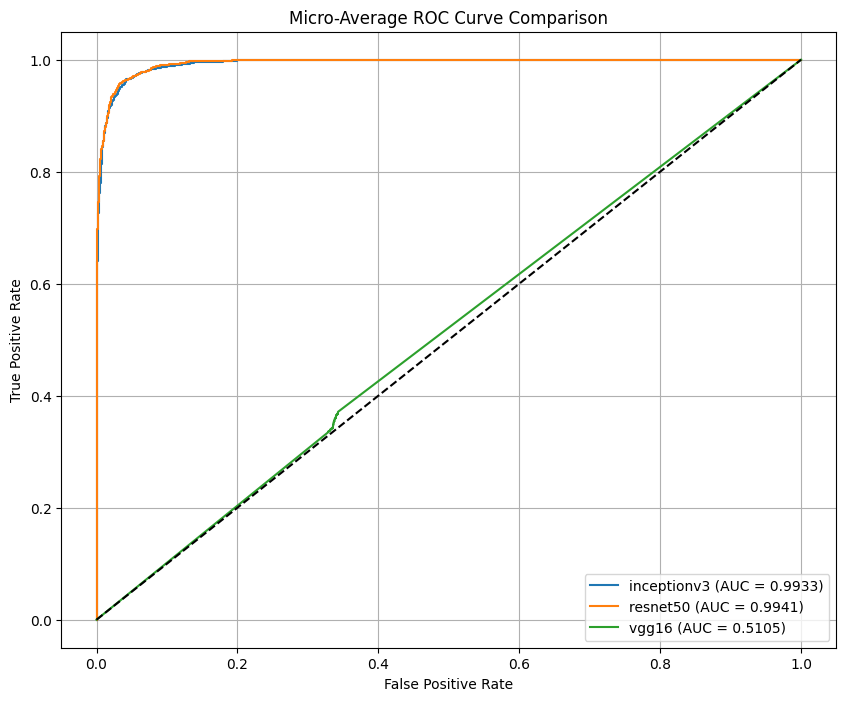

In [8]:
plt.figure(figsize=(10, 8))
for name, metrics in results.items():
    plt.plot(metrics['fpr'], metrics['tpr'], label=f"{name} (AUC = {metrics['micro_auc']:.4f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("Micro-Average ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

# Summary Table

In [9]:
summary_df = pd.DataFrame.from_dict(results, orient='index')
summary_df = summary_df[['accuracy', 'f1_macro', 'micro_auc']].round(4)
display(summary_df.sort_values(by='micro_auc', ascending=False))

,accuracy,f1_macro,micro_auc
resnet50,0.9453,0.9453,0.9941
inceptionv3,0.9391,0.9390,0.9933
vgg16,0.3378,0.1761,0.5105


# Saving Best Model to S3

In [10]:
best_model_name = summary_df['micro_auc'].idxmax()
best_model_path = MODEL_PATHS[best_model_name]
best_model_s3_key = f"model-artifacts/histopathology_model/best_histopathology_model_{best_model_name}.h5"

try:
    print(f"\n Uploading best model: {best_model_name}")
    s3.upload_file(best_model_path, S3_BUCKET_NAME, best_model_s3_key)
    print("Best model uploaded to S3.")
except NoCredentialsError:
    print("AWS credentials not found. Upload failed.")

print(f"Best Model: {best_model_name} | Micro-Average AUC = {summary_df.loc[best_model_name, 'micro_auc']:.4f}")


 Uploading best model: resnet50
Best model uploaded to S3.
Best Model: resnet50 | Micro-Average AUC = 0.9941
